# Autoencoders

Welcome our treasured friends, PyTorch and TorchVision.

In [3]:
import torch
import torchvision

As we will be using image data, we need to define some preprocessing.

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, )),
])

We will be using the MNIST dataset today.

In [5]:
data = torchvision.datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transform)

Processing...
Done!


Let's define a function to make Jupyter Notebook display our data.

In [6]:
from matplotlib.pyplot import imshow

def show_images(images):
    images = images.cpu()
    
    # Convert grayscale image into RGB channels.
    images = images.expand(-1, 3, -1, -1)
    
    # Make a grid view image of this batch.
    images = torchvision.utils.make_grid(images)
    
    # Unnormalize.
    images = images / 2 + 0.5
    
    # Convert PyTorch tensor to a NumPy array.
    images = images.numpy().transpose([1, 2, 0])
    
    # Display images.
    imshow(images)

Let's see how the data looks like!

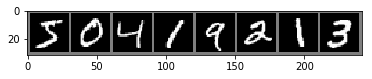

In [7]:
sample_batch = iter(torch.utils.data.DataLoader(
    data, shuffle=False, batch_size=8)).next()[0]
show_images(sample_batch)

Here's some idea of what we'll be building:
![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

Let's define our encoder and decoder modules separately. Simple models can be created with `torch.nn.Sequential`, which saves the effort of defining a class.

In [10]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 3, stride=3, padding=1), # (16, 10, 10)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=2), # (16, 5, 5)
    torch.nn.Conv2d(16, 8, 3, stride=2, padding=1), # (8, 3, 3)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=1) # (8, 2, 2)
)

decoder = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(8, 16, 3, stride=2), # (16, 5, 5)
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1), # (8, 15, 15)
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), # (1, 28, 28)
    torch.nn.Tanh()
)

print(encoder)
print(decoder)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (5): Tanh()
)


Don't forget the loss function and the optimizer. As we have two models, we need to let the optimizer know both.

In [11]:
criterion = torch.nn.MSELoss()

from itertools import chain
parameters = chain(encoder.parameters(), decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=1e-3, weight_decay=1e-15)

Here's some speedup for the lucky ones who have a GPU:

In [13]:
GPU_ID = 2

if torch.cuda.is_available():
    print('Using CUDA :)')
    sample_batch = sample_batch.cuda(device=GPU_ID)
    encoder = encoder.cuda(device=GPU_ID)
    decoder = decoder.cuda(device=GPU_ID)
    
else:
    print('No CUDA :(')

Using CUDA :)


Let's batchfiy our data now.

In [14]:
BATCH_SIZE = 512
NUM_WORKERS = 2
batches = torch.utils.data.DataLoader(
    dataset=data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
     drop_last=True)

Finally, let's get training!

In [15]:
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    with torch.set_grad_enabled(True):
        for image, target in batches:
            if torch.cuda.is_available():
                image = image.cuda(device=GPU_ID)

            code = encoder(image)
            reconstruction = decoder(code)
            loss = criterion(reconstruction, image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)
            
    print(f'epoch {epoch}: loss {epoch_loss/len(batches):.3f}')

epoch 0: loss 0.659
epoch 1: loss 0.419
epoch 2: loss 0.354
epoch 3: loss 0.319
epoch 4: loss 0.292
epoch 5: loss 0.249
epoch 6: loss 0.207
epoch 7: loss 0.188
epoch 8: loss 0.179
epoch 9: loss 0.173
epoch 10: loss 0.168
epoch 11: loss 0.165
epoch 12: loss 0.162
epoch 13: loss 0.159
epoch 14: loss 0.157
epoch 15: loss 0.155
epoch 16: loss 0.154
epoch 17: loss 0.153
epoch 18: loss 0.152
epoch 19: loss 0.151
epoch 20: loss 0.150
epoch 21: loss 0.150
epoch 22: loss 0.149
epoch 23: loss 0.148
epoch 24: loss 0.147
epoch 25: loss 0.147
epoch 26: loss 0.146
epoch 27: loss 0.146
epoch 28: loss 0.145
epoch 29: loss 0.145
epoch 30: loss 0.144
epoch 31: loss 0.144


Let's create a checkpoint here in case we need it...

In [19]:
import os

if os.path.isfile('autoencoder.pth'):
    print('There is a saved checkpoint already.')
else:
    torch.save([encoder.state_dict(), decoder.state_dict()], 'autoencoder.pth')

There is a saved checkpoint already.


So we can reload it with:

In [20]:
checkpoint = torch.load('autoencoder.pth')
encoder.load_state_dict(checkpoint[0])
decoder.load_state_dict(checkpoint[1])

Let's see the trained results. Here are the sample batch that we extracted earlier:

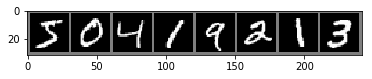

In [21]:
show_images(sample_batch)

And here are our autoencoder's reconstruction of them:

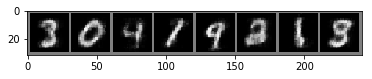

In [22]:
with torch.no_grad():
    show_images(decoder(encoder(sample_batch)))

What if we want to check the encoded result of a single image?

In [34]:
single_batch = sample_batch[0]
result = encoder(single_batch)
print(result)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 3, 3], but got input of size [1, 28, 28] instead

Oops! Let's try that again:

In [35]:
single_batch = sample_batch[0].unsqueeze(0)
result = encoder(single_batch)
print(result)

tensor([[[[11.3624, 11.3624],
          [11.3624, 11.3624]],

         [[14.5896, 14.5896],
          [14.5896, 14.5896]],

         [[17.8886, 17.8886],
          [17.8886, 17.8886]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 0.5733, 11.0399],
          [ 0.5733, 11.0399]],

         [[ 7.4776,  7.4776],
          [ 7.4776,  7.4776]],

         [[ 5.3631,  3.4502],
          [ 7.1815,  3.0058]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]],
       device='cuda:2', grad_fn=<MaxPool2DWithIndicesBackward>)


## Denoising autoencoder

Autoencoders can also be used to denoise images.

![](https://cdn-images-1.medium.com/max/1040/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)

First, we need to define the noise creating function:

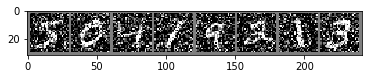

In [23]:
def add_noise(x):
    noise = torch.FloatTensor(x.size()).normal_(0, 1)
    if torch.cuda.is_available():
        noise = noise.cuda(device=GPU_ID)
    return (x + noise).clamp_(-1, 1)


noisy_sample = add_noise(sample_batch)
show_images(noisy_sample)

Let's start training!

In [24]:
NUM_EPOCHS = 64
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    with torch.set_grad_enabled(True):
        for image, target in batches:
            if torch.cuda.is_available():
                image = image.cuda(device=GPU_ID)
            
            noisy_image = add_noise(image)

            code = encoder(noisy_image)
            reconstruction = decoder(code)
            loss = criterion(reconstruction, image)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)
            
    print(f'epoch {epoch}: loss {epoch_loss/len(batches):.3f}')

epoch 0: loss 0.199
epoch 1: loss 0.183
epoch 2: loss 0.181
epoch 3: loss 0.180
epoch 4: loss 0.179
epoch 5: loss 0.178
epoch 6: loss 0.178
epoch 7: loss 0.177
epoch 8: loss 0.177
epoch 9: loss 0.176
epoch 10: loss 0.176
epoch 11: loss 0.175
epoch 12: loss 0.175
epoch 13: loss 0.175
epoch 14: loss 0.175
epoch 15: loss 0.174
epoch 16: loss 0.174
epoch 17: loss 0.174
epoch 18: loss 0.173
epoch 19: loss 0.173
epoch 20: loss 0.173
epoch 21: loss 0.173
epoch 22: loss 0.172
epoch 23: loss 0.172
epoch 24: loss 0.172
epoch 25: loss 0.172
epoch 26: loss 0.172
epoch 27: loss 0.171
epoch 28: loss 0.172
epoch 29: loss 0.171
epoch 30: loss 0.171
epoch 31: loss 0.171
epoch 32: loss 0.171
epoch 33: loss 0.170
epoch 34: loss 0.170
epoch 35: loss 0.170
epoch 36: loss 0.170
epoch 37: loss 0.170
epoch 38: loss 0.170
epoch 39: loss 0.170
epoch 40: loss 0.169
epoch 41: loss 0.169
epoch 42: loss 0.169
epoch 43: loss 0.169
epoch 44: loss 0.169
epoch 45: loss 0.169
epoch 46: loss 0.169
epoch 47: loss 0.169
ep

And again, it's always wise to save progress:

In [25]:
if os.path.isfile('denoising.pth'):
    print('A checkpoint already exists.')
else:
    torch.save([encoder.state_dict(), decoder.state_dict()], 'denoising.pth')

In [26]:
checkpoint = torch.load('denoising.pth')
encoder.load_state_dict(checkpoint[0])
decoder.load_state_dict(checkpoint[1])

Our noisy inputs were:

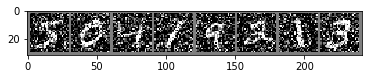

In [27]:
 show_images(noisy_sample)

The autoencoder have made them a bit better:

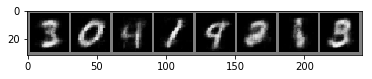

In [16]:
with torch.no_grad():
    show_images(decoder(encoder(noisy_sample)))